In [ ]:
!pip install chess onnxscript

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 36.0 MB/s eta 0:00:00
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=ff8132c661f35e911f1c88d640dc2a737725338bb8c35ba0791cda369a36244c
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [ ]:
import torch
import random
from torch import nn, onnx
from torch.nn import functional as F
from torch.optim import Adam
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

In [ ]:
import chess
import re
import json

# Подготовка и сохранение данных
# Для удобства дальнейшего использования
# Файл где есть некоторое количество игр в виде SAN
f = open("drive/MyDrive/data/chess_games.json")
data = json.load(f)
f.close()
dataset = []

for x in tqdm(range(len(data)), "preparing"):
    game = data[x]
    game = re.sub('\d*\. ', '', game).split()
    # Не рассматриваем игры где нет победителя-черного и его мата
    # Бот играет за черных на моём сайте (https://himer65.github.io/neuron/index.html)
    if game[-1] != "0-1": continue
    if game[-2][-1] != "#": continue
    board = chess.Board()
    seq = []

    for y in game[:-1]:
        move = board.push_san(y)
        # Обычное кодирование координат
        ten = [
            move.from_square %  8,  # вертикаль начальной позиции
            move.from_square // 8,  # горизонталь начальной позиции
            move.to_square %  8,  # вертикаль конечной позиции
            move.to_square // 8,  # горизонталь конечной позиции
        ]
        ten = torch.tensor(ten)
        ten = F.one_hot(ten, 8).bool().view(-1)
        seq.append(ten)

    dataset.append(torch.stack(seq))


torch.save(dataset, "drive/MyDrive/data/chess_games.pt")
print(f"\nsave {len(dataset)} games")
print("ура, победа")

preparing: 100%|██████████| 5388353/5388353 [1:06:50<00:00, 1343.45it/s]



save 661978 games
ура, победа


In [ ]:
class ChessData:
    def __init__(self,
                 path: str,
                 batch_size: int = 64,
                 device: str = "cpu"):
        self._data = torch.load(path, map_location=device, weights_only=True)
        self._b = batch_size
        self._s = 0

    def __next__(self) -> tuple[torch.Tensor]:
        self._shuffle()
        batch = self._data[self._b*self._s:self._b*(self._s+1)]
        batch = pack_sequence(batch, False).float()
        batch, lens = pad_packed_sequence(batch, batch_first=False)

        x = batch[:-1:2]  # на вход только ходы белых
        y = batch[1::2]  # на выход только ходы черных
        mask = torch.ones_like(y).bool()
        for idx, len_ in enumerate(lens//2):
            mask[len_:, idx, :] = False

        self._s += 1

        return (x, y, mask)

    def _shuffle(self) -> None:
        if len(self._data) <= self._b*self._s:
            random.shuffle(self._data)
            self._s = 0

In [ ]:
class PlanktonAI(nn.Module):
    _size_window: int = 8

    def __init__(self):
        super().__init__()
        self._cache = {}
        self.query = nn.Linear(32, 32)
        self.key = nn.Linear(32, 32)
        self.value = nn.Linear(32, 32)
        self.fc = nn.Linear(32, 32)

    def forward(self, games: torch.Tensor) -> torch.Tensor:
        #games size[seq, batch, p]
        query = F.sigmoid(self.query(games))
        key = F.tanh(self.key(games))
        value = F.tanh(self.value(games))
        #permute of dimensions. size[p, batch, seq]
        query = torch.transpose(query, 0, -1)
        key = torch.transpose(key, 0, -1)
        value = torch.transpose(value, 0, -1)
        #make window
        window = self._make_window(key.size(-1), key.device) #size[seq, seq]
        #window attention
        mat_attn = torch.matmul(query.unsqueeze(-1), key.unsqueeze(-2)) #?key, query? size[p, batch, seq, seq]
        mat_attn = mat_attn * window
        mat_attn = F.softmax(mat_attn, -1)
        mat_val = (value.unsqueeze(-2) * mat_attn).sum(-1) #size[p, batch, seq]
        result = torch.transpose(mat_val, 0, -1) #size[seq, batch, p]
        #finished
        out = F.sigmoid(self.fc(result))

        return out

    def _add_memmory(self, x: torch.Tensor) -> torch.Tensor:
        pass

    def _make_window(self,
                     seq: int,
                     device: torch.device) -> torch.Tensor:
        if seq in self._cache.keys():
            return self._cache[seq]

        window = torch.ones(seq, seq, device=device)
        window = torch.tril(window)
        window = torch.triu(window, -self._size_window + 1)
        self._cache[seq] = window

        return window

In [ ]:
num_param = lambda m: sum(p.numel() for p in m.parameters())

def conf_mat(x: torch.Tensor, #size[seq, batch, 32]
             y: torch.Tensor,
             mask: torch.Tensor) -> list["np.Array"]:
    seq, batch, _ = x.shape
    x = x.view(seq, batch, 4, 8).cpu()
    y = y.view(seq, batch, 4, 8).cpu()
    mask = mask.view(seq, batch, 4, 8)
    x = x.argmax(-1).view(-1, 4)
    y = y.argmax(-1).view(-1, 4)
    matrixs = []

    for idx in range(4):
        xn, yn = x[:,idx], y[:,idx]
        maskn = mask[:, :, idx]
        mat = confusion_matrix(yn, xn)
        # Избавляемся от заполнений
        mat[0, 0] -= (maskn.numel() - maskn.sum()) / 8
        matrixs.append(mat)

    return matrixs

def train(model: PlanktonAI,
          optimizer: Adam,
          dataset: ChessData,
          loops: int = 64) -> None:
    model.train()
    losses, L = [], 0

    for idx in tqdm(range(loops), "Train model"):
        x, y, mask = next(dataset)
        out = model(x) * mask
        loss = F.mse_loss(out, y)

        loss.backward()
        optimizer.step()
        model.zero_grad()
        L += loss.item()

        if (idx % 100) == 99:
            losses.append(L / 100); L = 0

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, layout="constrained")
    fig.suptitle("Relative error matrix of each coordinate")
    ax1.set_title("\"X\" initial")
    ax2.set_title("\"Y\" initial")
    ax3.set_title("\"X\" final")
    ax4.set_title("\"Y\" final")
    matrixs = conf_mat(out, y, mask)
    for ax, mat in zip([ax1, ax2, ax3, ax4], matrixs):
        ax.imshow(mat, cmap="inferno")

    plt.show()

    plt.plot(losses)
    plt.title("Loss")
    plt.xlabel("loop")
    plt.ylabel("loss")
    plt.show()

In [11]:
plankton = PlanktonAI().cuda()
optim = Adam(
    plankton.parameters(),
    lr=1e-4,
    fused=True,
)
dataset = ChessData(
    path = "drive/MyDrive/data/chess_games.pt",
    batch_size = 128,
    device = "cuda",
)

print(f"Number parameters in Model: {num_param(plankton)}")
print(plankton)

Number parameters in Model: 4224
PlanktonAI(
  (query): Linear(in_features=32, out_features=32, bias=True)
  (key): Linear(in_features=32, out_features=32, bias=True)
  (value): Linear(in_features=32, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
)


Train model: 100%|██████████| 16384/16384 [10:31<00:00, 25.94it/s]


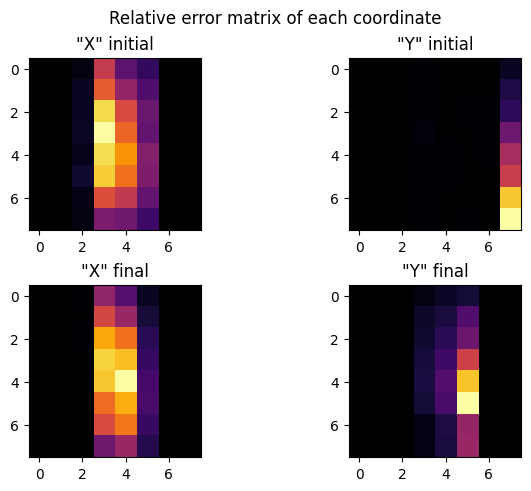

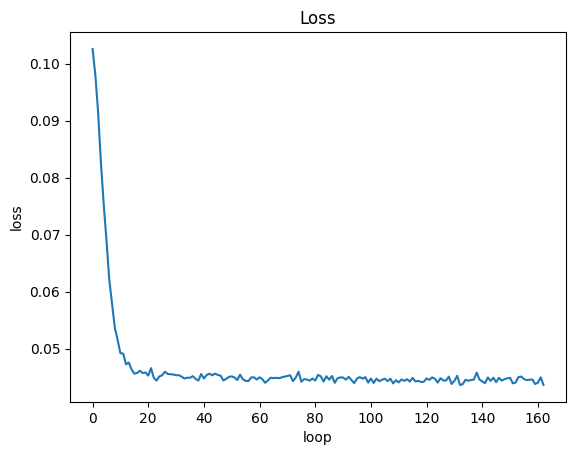

In [12]:
train(
    model = plankton,
    optimizer = optim,
    dataset = dataset,
    loops = 2**14,
)

In [13]:
from torch.profiler import profile, ProfilerActivity

input = torch.rand(1, 1, 32)
plankton.cpu().eval()

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    plankton(input)

print(prof.key_averages().table(sort_by="cpu_time_total"))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
          aten::linear         9.12%      57.643us        52.36%     331.008us      82.752us             4  
           aten::addmm        16.69%     105.503us        22.53%     142.399us      35.600us             4  
               aten::t         8.61%      54.435us        13.05%      82.503us      20.626us             4  
          aten::matmul         3.06%      19.352us        11.97%      75.654us      75.654us             1  
       aten::transpose         7.30%      46.170us         8.97%      56.735us       7.092us             8  
         aten::reshape         2.74%      17.342us         7.14%      45.136us       7.523us             6  
            aten::v

In [14]:
#Save
input = torch.rand(5, 1, 32)
plankton.cpu().eval()
onnx_plankton = onnx.dynamo_export(plankton, input)
onnx_plankton.save("plankton.onnx")
print("succses")

/usr/local/lib/python3.11/dist-packages/torch/onnx/_internal/_exporter_legacy.py:116: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


Applied 5 of general pattern rewrite rules.
succses
